In [1]:
!nvidia-smi

Sun May  3 13:30:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

Uninstalling torch-1.5.0+cu101:
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 44.1MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/facemask/Face Mask Detection.zip', 'r') as zip_ref:
    zip_ref.extractall()

### Load libraries and read the data

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from sklearn.metrics import f1_score
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
import shutil
import cv2
import glob

# Any results you write to the current directory are saved as output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- lets import the fastai libraries 

In [0]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *

In [0]:
pos = os.listdir('Positive')
neg = os.listdir('Negative')

for i in pos:
  shutil.copy('Positive/' + i, 'images/' + 'pos_' + i)

for i in neg:
  shutil.copy('Negative/' + i, 'images/' + 'neg_' + i)

In [27]:
df = pd.DataFrame(list(os.listdir('images/')), columns = ['image'])
lst = []
for i in df['image']:
  if i.startswith('pos'):
    lst.append('positive')
  else:
    lst.append('negative')
df['label'] = lst
df = shuffle(df)
df.to_csv("image_data.csv", index = False)
df.head(2)

,image,label
102,pos_000057.jpg,positive
0,neg_000228.jpg,negative


In [0]:
## read the csv data files
train_df = pd.read_csv('image_data.csv')[:int(len(df)*0.8)]
test_df = pd.read_csv('image_data.csv')[int(len(df)*0.8):]

In [29]:
train_df.shape, test_df.shape

((136, 2), (35, 2))

In [30]:
train_df.head()

,image,label
0,pos_000057.jpg,positive
1,neg_000228.jpg,negative
2,neg_000100.jpg,negative
3,pos_000089.jpg,positive
4,neg_000072.jpg,negative


In [31]:
test_df.head()

,image,label
136,neg_000156.jpg,negative
137,pos_000011.jpg,positive
138,pos_000005.jpg,positive
139,pos_000082.jpg,positive
140,neg_000083.jpg,negative


In [0]:
# submit.head()

In [33]:
train_df.groupby('label').count()

,image
label,
negative,82
positive,54


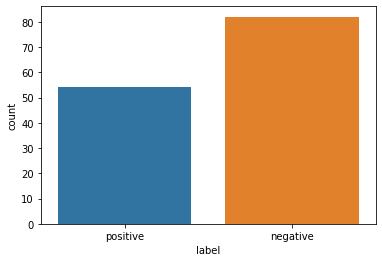

In [34]:
sns.countplot(x='label' , data=train_df)

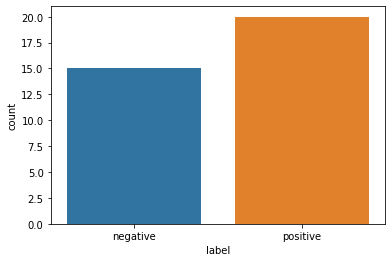

In [35]:
sns.countplot(x='label' , data=test_df)

In [0]:
data_path = "images/"
#path = os.path.join(data_path , "*jpg")

In [37]:
train_images = []
for file in train_df['image']:
    image = cv2.imread(data_path + file)
    train_images.append(image)

train_images[0].shape

(534, 625, 3)

In [38]:
test_images = []
for file in test_df['image']:
    image = cv2.imread(data_path + file)
    test_images.append(image)

test_images[0].shape

(525, 700, 3)

In [0]:
def plot_class(cat):
    
    fetch = train_df.loc[train_df['label']== cat][:3]
    fig = plt.figure(figsize=(20,15))
    
    for i , index in enumerate(fetch.index ,1):
        plt.subplot(1,3 ,i)
        plt.imshow(train_images[index])
        plt.xlabel(cat + "(Index:" +str(index)+")" )
    plt.show()

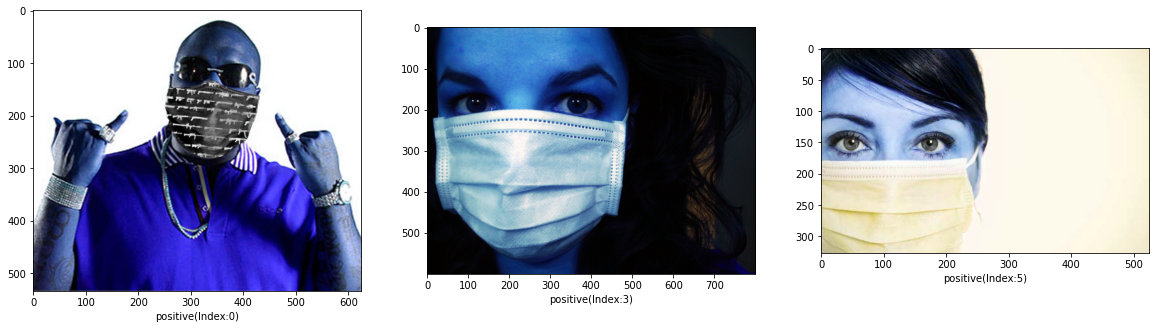

In [40]:
plot_class('positive')

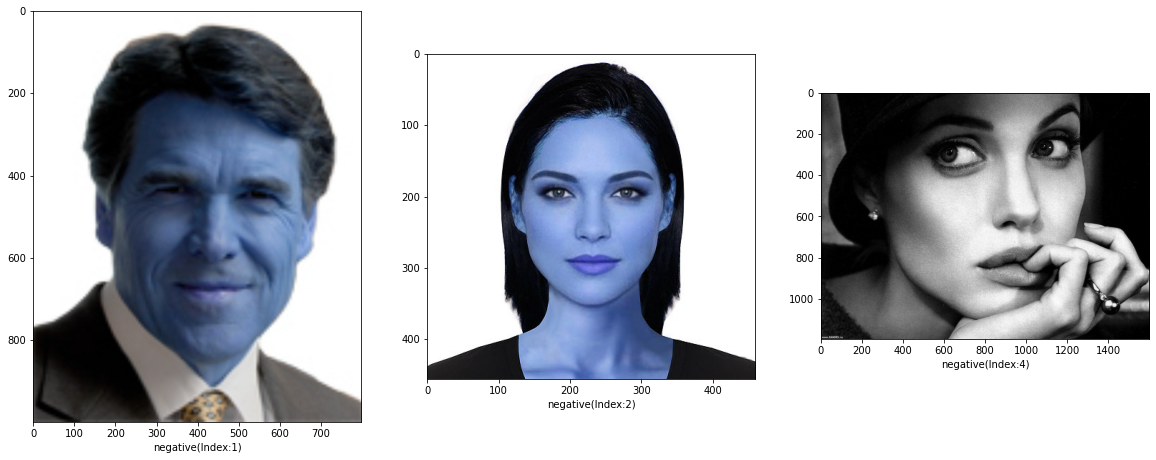

In [41]:
plot_class('negative')

### Modelling Approach

In [0]:
##transformations to be done to images
tfms = get_transforms(do_flip=False,flip_vert=False ,max_rotate=10.0, max_zoom=1.22, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                      p_lighting=0.75)

## create databunch of test set to be passed
test_img = ImageList.from_df(test_df, path='/content/', folder='images')

In [0]:
np.random.seed(145)
## create source of train image databunch
src = (ImageList.from_df(train_df, path='/content/', folder='images')
       .split_by_rand_pct(0.2)
       .label_from_df()
       .add_test(test_img))

In [0]:
data = (src.transform(tfms, size=299,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='', bs=32, device= torch.device('cuda:0')).normalize(imagenet_stats))

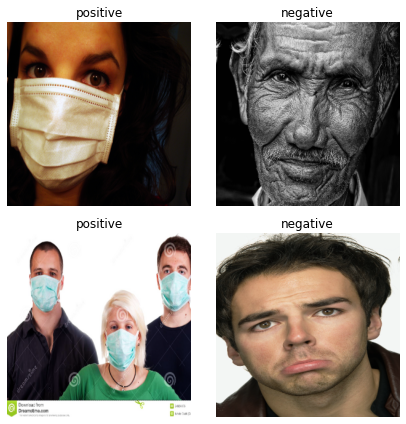

In [62]:
data.show_batch(rows=2, figsize=(6,6))

In [63]:
print(data.classes)

['negative', 'positive']


## Creating cnn learner. 

In [0]:
learn = cnn_learner(data=data, base_arch=models.resnet101, metrics=[FBeta(beta=1, average='macro'), accuracy],
                    callback_fns=ShowGraph)

In [65]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 1.45E-02


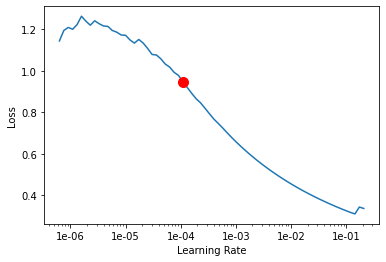

In [0]:
#lets find the correct learning rate to be used from lr finder
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,1.628069,0.786910,0.386364,0.407407,00:10
1,1.539719,0.718080,0.554945,0.555556,00:10
2,1.320761,0.641294,0.666667,0.666667,00:09
3,1.144873,0.435427,0.775000,0.777778,00:10
4,0.949795,0.268872,0.883117,0.888889,00:11
5,0.830411,0.168809,0.959399,0.962963,00:10
6,0.718843,0.126155,0.959399,0.962963,00:10
7,0.625069,0.105932,0.959399,0.962963,00:11
8,0.562227,0.084782,0.959399,0.962963,00:09
9,0.509373,0.077097,0.959399,0.962963,00:10


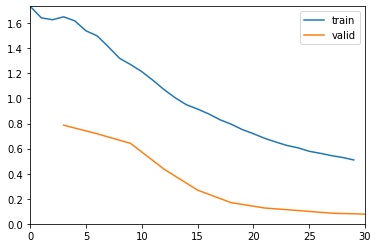

In [66]:
lr = 1e-04
#learn.fit_one_cycle(10, slice(lr))
learn.fit_one_cycle(10, slice(lr), wd=0.2)

### Interpretation

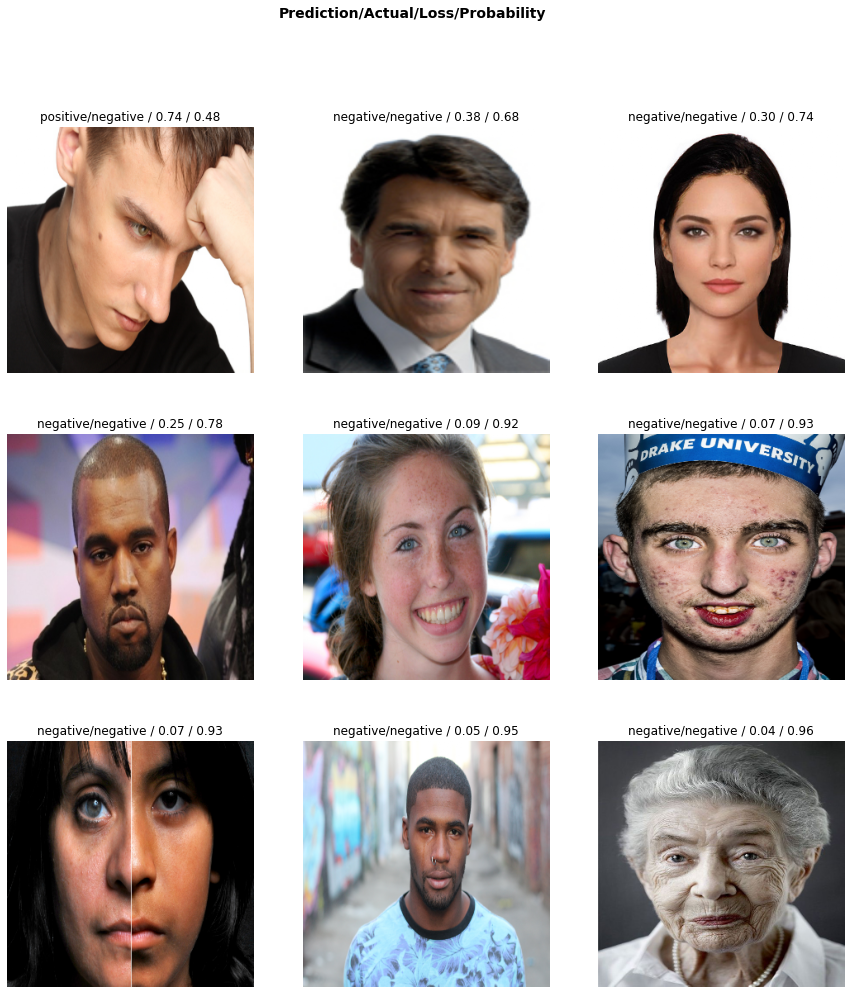

In [67]:
#lets see the most mis-classified images (on validation set)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,16))

### Confusion Matrix

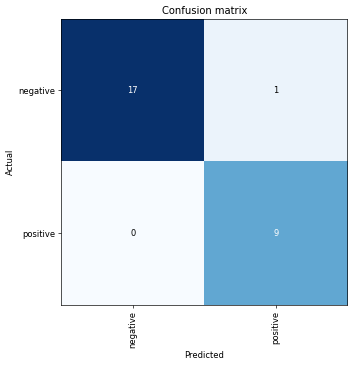

In [69]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60) ## on validation set

### Edge Detection

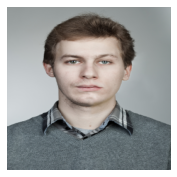

In [71]:
idx=5
x,y = data.valid_ds[idx]
x.show()

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [73]:
t = data.valid_ds[5][0].data; t.shape

torch.Size([3, 299, 299])

In [0]:
edge = F.conv2d(t[None], k)

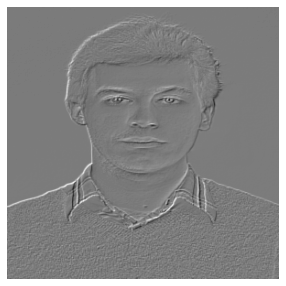

In [75]:
show_image(edge[0], figsize=(5,5));

### Heatmaps

In [0]:
m = learn.model.eval();
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [78]:
hook_a,hook_g = hooked_backward()
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 10, 10])

In [79]:
avg_acts = acts.mean(0)
avg_acts.shape
torch.Size([11, 11])

torch.Size([11, 11])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

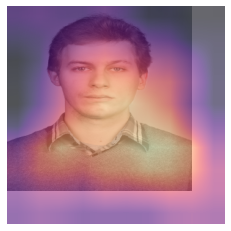

In [81]:
show_heatmap(avg_acts)

In [82]:
##learn.TTA improves score further. lets see for the validation set
pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
from sklearn.metrics import f1_score, accuracy_score
valid_preds = [np.argmax(pred_val[i])+1 for i in range(len(pred_val))]
valid_preds = np.array(valid_preds)
y = np.array(y+1)
accuracy_score(valid_preds,y),f1_score(valid_preds,y, average='micro')

(1.0, 1.0)

### We got an accuracy and F1 score of 1 on our validation dataset